In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

**Reference**: https://towardsdatascience.com/ab-testing-with-python-e5964dd66143

**Data**: Data contains results of an A/B test on what seems to be 2 different designs of a website page (old_page vs new_page).
https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv

**General Steps to tackle A/B Testing** (see OneNote Studying Cheat Sheet):
- Define a success metric
- State the hypothesis (i.e., `Ho` = no difference b/w control and treatment vs `Ha` = difference)
- Define the statistic parameters (e.g., alpha, power, MDE)
- Randomization unit (i.e., splitting groups)
- Determine the sample size
- Estimate the experimentation time
- Perform test for statistical significance (i.e., pairwise t-test to compare two sample means)
- Make final business decision to launch the new feature or not

**Scenario Background**: You work on the product team at a medium-sized online ECOMM business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The PM told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%. In other words, the new design will be considered a success if it raises the conversion rate to 15%.

### 1. Define a Success Metric

Based on the scenario, our success metric has been established for us in talks with the UX designer and Project Manager. The success rate will be **conversion rate** - specifically if it increases to 15%.

It will be calculated based on every user session with a binary variable, where `0` = user did not buy the product during this user session and `1` = user bought the product during this user session.

### 2. Formulate a Hypothesis

The null hypothesis is that there is no difference in performance between the old website (control = c) and new website (treatment = t). The alternative hypothesis is that there is a difference in performance between the two.

`Ho: mu_c = mu_t`

`Ha: mu_c != mu_t`

### 3. Define Statistical Parameters

Let's set a confidence level of 95%. This means that our critical value `α = 0.05` (industry standard). We will also set `power = 0.80` (also industry standard). Recall that power is `1-β` (Type II Error).

### 4. Sample Randomization

We know we need two samples. Having a control group allows us to directly compare their results to the treatment group, because the only systematic difference between the two groups is the actual design of the product page (i.e., what we're evaluating the impact of). Therefore, we can attribute any differences in results to the designs.

1. A control group: They'll be shown the old design
2. A treatment group: They'll be shown the new design

*How do we form the groups?*

### 5. Determine Sample Size

It's important to remember that since we can't test our *whole* user base, the conversion rates that we'll get will just be *estimates* of the true rates.

The larger the sample size (i.e., number of user sessions we capture in each group), the more precise our estimates and the higher the chance to detect a difference in the two groups, if present. However, the larger the sample, the more expensive the study becomes.

We can perform **Power analysis** to determine our necessary sample size. We require the following metrics (see statistical parameters above):

- Power `(1 — β)`: This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention.
- Alpha value `(α)`: The critical value we set earlier - 0.05 is typically industry standard.
- Effect Size: How big of a difference we expect there to be between the success metric (i.e., conversion rate in our case).

In [93]:
#first calculate effect size (statsmodels library)

effect_size = sms.proportion_effectsize(0.13, 0.15)

    # we can use 13% as prop1 since this is the original conversion rate
    # 15% as prop2 since this is the rate we're hoping for

In [94]:
#now we can use formula for our required sample size
#NormalIndPower() is used for power calculations for 2 independent samples

required_n = sms.NormalIndPower().solve_power(effect_size = effect_size,
                                             power = 0.8,
                                             alpha = 0.05,
                                             ratio = 1 #for even samples
                                             )

#round up
required_n = ceil(required_n)

print(required_n)

4720


The results of our power test indicate that we'll want at least 4720 observations for each group.

### 6. Experimentation Time + Collecting & Preprocessing Data

Typically after establishing the required sample size, you would work with your team to set up the experiment and start collecting the data over a pre-determined amount of time (e.g., run the experiment over the course of 2 weeks).

We'll simulate this and assume that the Kaggle data represents the data resulting from our experiment.

In [95]:
#import data
df = pd.read_csv('ab_data.csv')

In [96]:
#preview df
df.head() #note our dependent var - converted

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [98]:
#check if all control group are seeing old_page; same for treatment group
pd.crosstab(df['group'], df['landing_page'])
    #observe that most of control sees old_page and most of treatment sees new page, but not 100%

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [99]:
#check for duplicate users
session_counts = df['user_id'].value_counts(ascending = False)

session_counts #can clearly see there are users with duplicate sessions

637561    2
821876    2
643869    2
938802    2
916765    2
         ..
710897    1
708848    1
665839    1
663790    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [100]:
#how many duplicate users exactly?
multi_users = session_counts[session_counts > 1].count()

multi_users #there are 3894 users that appear twice in the dataset

3894

In [101]:
#we'll drop the duplicates from the df to avoid sampling them twice
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)] #this is how you do NOT IN in pandas

In [102]:
#recheck the split of our samples
pd.crosstab(df['group'], df['landing_page'])
    #suddenly they just so happen to appear "pure"

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


Now we'll take a subset of these two larger samples based on the power test we ran above. **Note** that you wouldn't typically have to do this (would just run on all the responses collected), but will illustrate since we calculated our required sample earlier through the power analysis.

In [103]:
#recall that we want n = 4720 for each of the groups - control and treatment

control_sample = df[df.group == 'control'].sample(n = required_n,
                                                  random_state = 1024)
treatment_sample = df[df.group == 'treatment'].sample(n = required_n,
                                                     random_state = 1024)

In [104]:
#union samples
ab_test = pd.concat([control_sample, treatment_sample]).reset_index(drop = True)

ab_test #now we see 9440 total records (4720 per)

,user_id,timestamp,group,landing_page,converted
0,635545,2017-01-04 06:20:23.366946,control,old_page,1
1,730678,2017-01-12 13:42:17.940032,control,old_page,0
2,787893,2017-01-06 21:59:10.486556,control,old_page,0
3,943389,2017-01-07 05:12:42.192200,control,old_page,1
4,759494,2017-01-03 07:05:49.738914,control,old_page,0
...,...,...,...,...,...
9435,872884,2017-01-09 04:05:06.543469,treatment,new_page,0
9436,745323,2017-01-03 14:40:37.600372,treatment,new_page,0
9437,845068,2017-01-03 03:45:36.776806,treatment,new_page,0
9438,779868,2017-01-07 01:17:12.157249,treatment,new_page,0


In [105]:
#quickly just confirm value counts
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [107]:
#export if needed
#ab_test.to_csv("ab_test_proportions.csv", index=False)

### 7) Perform Test for Statistical Significance

#### EDA

First we can calculate some basic summary statistics to compare our two samples at a high-level.

In [79]:
#standard deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)

#std error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean, std_p, se_p])
    #note that agg is handy for adding multiple values after a groupby
    
#edit column names
conversion_rates.columns = ['conversion_rate','std_deviation','std_error']

conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.122246,0.327569,0.004768
treatment,0.116949,0.321360,0.004678


Judging by the stats above, it looks like the two designs performed **very similarly**. Based on our sample (recall we took a subset of Kaggle's), it looks like the new webpage is actually performing **slightly worse** than the original design, with an **11.7%** conversion rate vs **12.2%**.

Text(0, 0.5, 'Conversion Rate')

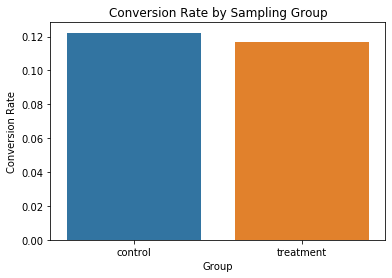

In [82]:
#can plot this if we wanted to
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.title('Conversion Rate by Sampling Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')

Based on the EDA of our results, we'd be inclined to say that the new webpage design had no beneficial impact on consumers. But, we'll go through the scientific procedure of performing statistical testing to ensure that this is the case.

#### Statistical Testing

Having a large enough sample (recall power analysis), allows us to assume normal distribution when calculating our p-value. Note that we're using a z-test below.

Generally in A/B Testing, we'll turn to a two-sample t-test (e.g., Welch's) or a pairwise t-test to compare our two sample means.

- Two-sample t-test: When the data in the two samples are statistically independent
- Pairwise t-test: When the data is in the form of matched pairs

We can reference the flow chart below:
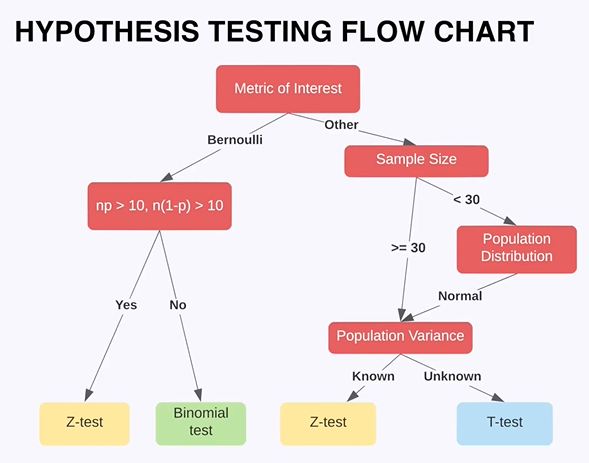

- We are dealing with a Bernoulli distribution since we're evaluating the proportions of people who clicked through and purchased with the new web design vs the old design.
- We also know that `n = 4720` and `Pr(conversion) = 0.13` (we'll assume the current conversion rate pre-testing). This easily passes the tests required to assume normality by the CLT. Recall `np > 10` and `n(1-p) > 10`

`np = (4720)(0.13) = 614` and `n(1-p) = (4720)(0.87) = 4106`

- As a result we can go ahead with a Z-test

In [91]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test.group == 'control']['converted']
treatment_results = ab_test[ab_test.group == 'treatment']['converted']

n_con = control_results.count() #count of control
n_treat = treatment_results.count() #count of treatment
successes = [control_results.sum(), treatment_results.sum()]
n_obs = [n_con, n_treat]

z_stat, pval = proportions_ztest(count = successes,
                                nobs = n_obs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(count = successes,
                  nobs = n_obs,
                  alpha = 0.05)

print(f'z-score: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z-score: 0.793
p-value: 0.428
ci 95% for control group: [0.113, 0.132]
ci 95% for treatment group: [0.108, 0.126]


We see that the p-value is well above our critical value of `alpha = 0.05`, and therefore we **fail to reject the null hypothesis**.

In this specific case (based on the sample we drew from Kaggle), rejecting the null would actually be accepting that the original web design performed significantly better than the new design since the conversion rate observed was higher for the control group than the treatment group (see confidence intervals and positive z-score).

### 8) Make Final Business Decision

Tying things back to the business (always critical to do), the results of our A/B testing indicate that our new web design **did not** perform significantly different (let alone better) than our old one. As a result, we should probably pivot away from the proposed changes and consider altering different product/web features that may have better success with our customers.